# 2D Nerve Surface Segmentation 

**Add Proper References Here**

In [1]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

The objects (nerves) in the image have two different sizes which need to be handled differently. With small nerves marked in red an large in blue.

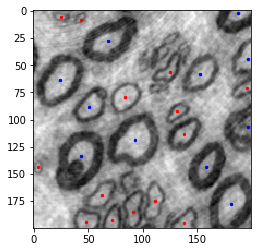

Number of objects: 25


In [2]:
# Load data
in_dir = 'data/'
data = imread(in_dir+'nerves2D.png').astype(np.int32)

# Get centers
path = in_dir+'nerveCenters.png'
centers = imread(path)[...,0]

centers_small = np.transpose(np.where(centers==1))
centers_large = np.transpose(np.where(centers==2))


# Show image with centers.
plt.imshow(data, cmap='gray')
plt.scatter(centers_small[..., 1], centers_small[..., 0], color='red', s=6)
plt.scatter(centers_large[..., 1], centers_large[..., 0], color='blue', s=6)
plt.show()

print(f'Number of objects: {len(centers_small)+len(centers_large)}')

## Unfolding
To detect the objects (nerves) using layered surface detection, we first need to unfold the nerves using a radial resampling.

In [3]:
from scipy.ndimage.interpolation import map_coordinates

def unfold_image(img, center, max_dists=None, r_min=1, r_max=20, angles=30, steps=15):
    """ Unfolds around a point in an image with radial resampling """
    # Sampling angles and radii.
    angles = np.linspace(0, 2*np.pi, angles, endpoint=False)
    distances = np.linspace(r_min, r_max, steps, endpoint=True)
    
    if max_dists is not None:
        max_dists.append(np.max(distances))
    
    # Get angles.
    angles_cos = np.cos(angles)
    angles_sin = np.sin(angles)
    
    # Calculate points positions.
    x_pos = center[0] + np.outer(angles_cos, distances)
    y_pos = center[1] + np.outer(angles_sin, distances)
    
    # Create list of sampling points.
    sampling_points = np.array([x_pos, y_pos]).transpose()
    sampling_shape = sampling_points.shape
    sampling_points_flat = sampling_points.reshape((-1, 2))
    
    # Sample from image.
    samples = map_coordinates(img, sampling_points_flat.transpose(), mode='nearest')
    samples = samples.reshape(sampling_shape[:2])
        
    return samples, sampling_points

Now that we have a function for unfolding image data, let's test it. The result should be an unfolded image, for which we can use layer detection.

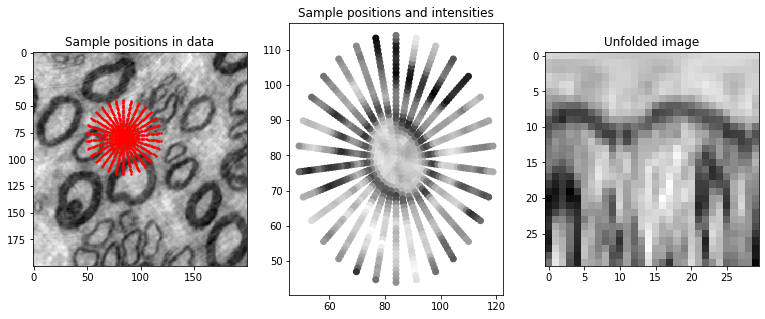

In [5]:
samples, sample_points = unfold_image(data, centers_small[4],r_max=35,angles=30,steps=30)

plt.figure(figsize=(13, 5))
ax = plt.subplot(1, 3, 1, title='Sample positions in data')
ax.imshow(data, cmap='gray')
ax.scatter(sample_points[..., 1], sample_points[..., 0], s=2, color='red')
ax = plt.subplot(1, 3, 2, title='Sample positions and intensities')
ax.scatter(sample_points[..., 1], sample_points[..., 0], c=samples, cmap='gray')
ax = plt.subplot(1, 3, 3, title='Unfolded image')
ax.imshow(samples, cmap='gray')
plt.show()

## Detect layers in object
Now that we can unfold the nerves, we can try to use graph cut based layer detection.

Since we want to separate the inner and outer part of the nerve, we will detect two layers per nerve. We will use the gradient image for this.

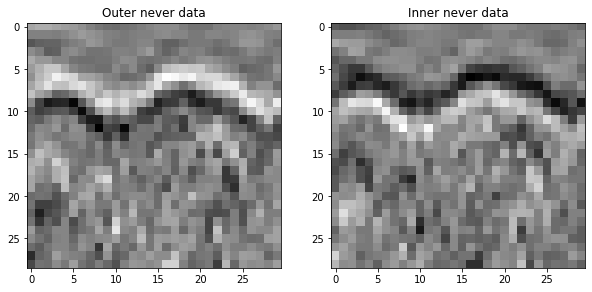

In [7]:
from slgbuilder import GraphObject,MaxflowBuilder

# Create gradient-based objects.
diff_samples = np.diff(samples, axis=0)
outer_nerve = GraphObject(255 - diff_samples)
inner_nerve = GraphObject(diff_samples)

f,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(outer_nerve.data, cmap='gray')
ax[0].set_title('Outer never data')
ax[1].imshow(inner_nerve.data, cmap='gray')
ax[1].set_title('Inner never data')
plt.show()

The surface will be detected where the data pixel intensity in the images are low. This corresponds well with the data for the outer and inner nerves shown above.

Let's detect the layers. We apply boundary cost, smoothness and containment constraints. Here we set both ```min_margin``` and ```max_margin``` constraints for our containment. Then we use ```maxflow``` to find the optimal solution.

In [8]:
helper = MaxflowBuilder()
helper.add_objects([outer_nerve, inner_nerve])
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)
helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)

flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 4754


We can then get the segmentations and the segmentation lines from the *GraphObject*

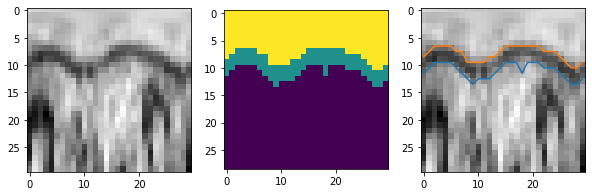

In [9]:
segmentations = [helper.get_labels(o).astype(np.int32) for o in helper.objects]
segmentation_lines = [np.count_nonzero(s, axis=0) - 0.5 for s in segmentations]

# Draw segmentation
f,ax = plt.subplots(1,3,figsize = (10,10))
ax[0].imshow(samples, cmap='gray')
ax[1].imshow(np.sum(segmentations,axis=0))
ax[2].imshow(samples, cmap='gray')
for line in segmentation_lines:
    ax[2].plot(line)
plt.show()

## Detecting multiple objects
In the image data here we have marked 25 different nerves that we would like to segment. We could segment each of these individually, the same way we segmented the single nerve above. To get a better segmentation the large nerves will need to be samples with slightly different parameters than the smaller ones. Although it is not the most memory efficient way of segmenting the objects, we could just add all the object to the graph at once and get a segmentation for each object.

In [10]:
# Lists for storing nerve objects.
nerve_samples = []
outer_nerves = []
inner_nerves = []

# For each center, create an inner and outer never.
for center in centers_small:
        samples, sample_points = unfold_image(data, center,r_max=35,angles=40,steps=30)
        nerve_samples.append(samples)
        
        # Create outer and inner nerve objects.
        diff_samples = np.diff(samples, axis=0)
        diff_sample_points = sample_points[:-1]
    

        outer_nerves.append(GraphObject(255 - diff_samples, diff_sample_points))
        inner_nerves.append(GraphObject(diff_samples, diff_sample_points))
for center in centers_large:
        samples, sample_points = unfold_image(data, center,r_max=60,angles=40,steps=30)
        nerve_samples.append(samples)
        
        # Create outer and inner nerve objects.
        diff_samples = np.diff(samples, axis=0)
        diff_sample_points = sample_points[:-1]
    

        outer_nerves.append(GraphObject(255 - diff_samples, diff_sample_points))
        inner_nerves.append(GraphObject(diff_samples, diff_sample_points))

Here we also add the sample positions to the ```GraphObject```s as they are needed to draw the sementations on the nerve image.

In [11]:
helper = MaxflowBuilder()
helper.add_objects(outer_nerves + inner_nerves)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)

for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)
    
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 212430


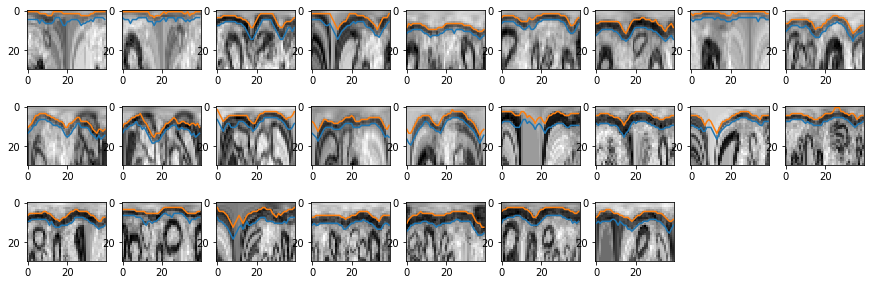

In [12]:
# Get segmentations.
segmentations = []
for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    segmentations.append(helper.get_labels(outer_nerve))
    segmentations.append(helper.get_labels(inner_nerve))

segmentation_lines = [np.count_nonzero(s, axis=0) - 0.5 for s in segmentations]

# Draw segmentations.
plt.figure(figsize=(15, 5))
for i, samples in enumerate(nerve_samples):
    ax = plt.subplot(3, len(nerve_samples) // 3 + 1, i + 1)
    ax.imshow(samples, cmap='gray')
    
    ax.plot(segmentation_lines[2*i])
    ax.plot(segmentation_lines[2*i + 1])

plt.show()

While most of the segmentations went well, if we look closely we see that some don't look right. If we draw the lines on the original image, we see the problem.

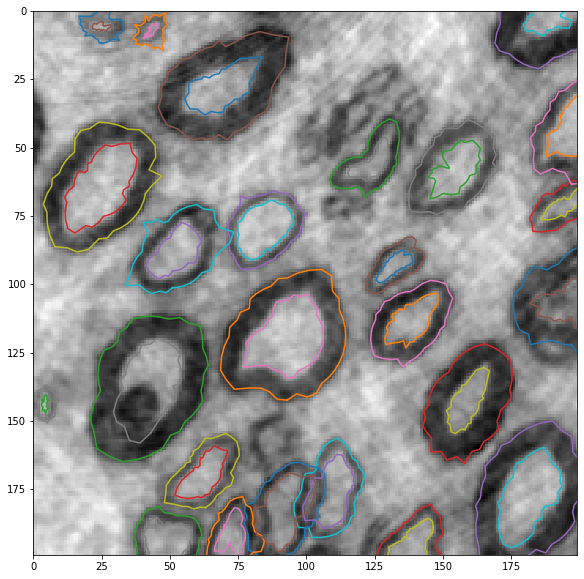

In [13]:
def draw_segmentations(data, helper):
    """Draw all segmentations for objects in the helper on top of the data."""
    
    # Create figure.
    plt.figure(figsize=(10, 10))
    plt.imshow(data, cmap='gray')
    plt.xlim([0, data.shape[1]-1])
    plt.ylim([data.shape[0]-1, 0])

    # Draw segmentation lines.
    for i, obj in enumerate(helper.objects):

        # Get segmentation.
        segment = helper.get_labels(obj)

        # Create line.
        line = np.count_nonzero(segment, axis=0)

        # Get actual points.
        point_indices = tuple(np.asarray([line - 1, np.arange(len(line))]))
        points = obj.sample_points[point_indices]
        # Close line.
        points = np.append(points, points[:1], axis=0)

        # Plot points.
        plt.plot(points[..., 1], points[..., 0])

    plt.show()
    
draw_segmentations(data, helper)

<!-- Some of the objects' segmentation are overlapping -->

Some of the objects' segmentation are overlapping

## Multi-object exclusion
To overcome the issue of overlapping segments, we can add exclusion contraints between all outer nerves. However, exclusion is a so-called *nonsubmodular* energy term, which means it cannot be represented as a single edge in our graph. Luckily there's an algorithm called *QPBO* (Qudratic Pseudo-Boolean Optimization) that can help us. 

QPBO creates creates a complementary graph, alongside the original graph. The complementary graph is inverted, meaning that is has the exact same edges as the original graph, except they are reversed. This means that the graph size is doubled, which makes computation slower and uses more memory. The benefit of QPBO is that we can now add nonsubmodular energies such as exclusion. 

The ```graphhelper``` module contains a ```QPBOHelper``` class, which is very similar to the ```GraphHelper``` we've been using so far. The main difference is that it has functions for adding exclusion. One of these is ```add_layered_exclusion``` which we will now use. We will be using the ```GraphObject```s created earlier.

In [14]:
from slgbuilder import QPBOBuilder

helper = QPBOBuilder()
helper.add_objects(outer_nerves + inner_nerves)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)

for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)
    
twice_flow = helper.solve()
print('Two times maximum flow/minimum energy:', twice_flow)

if 2*flow == twice_flow:
    print('QPBO flow is exactly twice the Maxflow flow.')
else:
    print('Something is wrong...')

Two times maximum flow/minimum energy: 424860
QPBO flow is exactly twice the Maxflow flow.


We see that the ```QPBOHelper``` energy/flow is exactly twice the flow computed by ```GraphHelper``` for a similar problem, which is what we expect, since we double the number of nodes and edges. This is because we have added exactly the same edges/energies on above. This of course also means that the segmentation is exactly the same, hence we haven't fixed the problem yet. 

To avoid the overlapping nerve segments, we add exclusion between all *outer* nerve objects using ```add_layered_exclusion``` and call ```solve``` again. Note that calculating the new maxflow/mincut only requires us to re-evaluate parts of the graph that were changed, potentially making the computation very fast.

In [15]:
# Add exclusion constraints between all pairs of outer nerves.
for i in range(len(outer_nerves)):
    for j in range(i + 1, len(outer_nerves)):
        helper.add_layered_exclusion(outer_nerves[i], outer_nerves[j], margin=3)
        
twice_flow = helper.solve()
print('Two times maximum flow/minimum energy:', twice_flow)


Two times maximum flow/minimum energy: 425476


We see that adding the new constraints has increased the energy. This makes sense, since our constraints are forcing a solution that is less optimal from the perspective of the data. However, our prior knowledge tells us that nerves cannot overlap, so even if the data suggest that they do, we know this is not the case, but rather because the data is inaccurate.

Let's draw the segmentation results with exclusion inteactions.

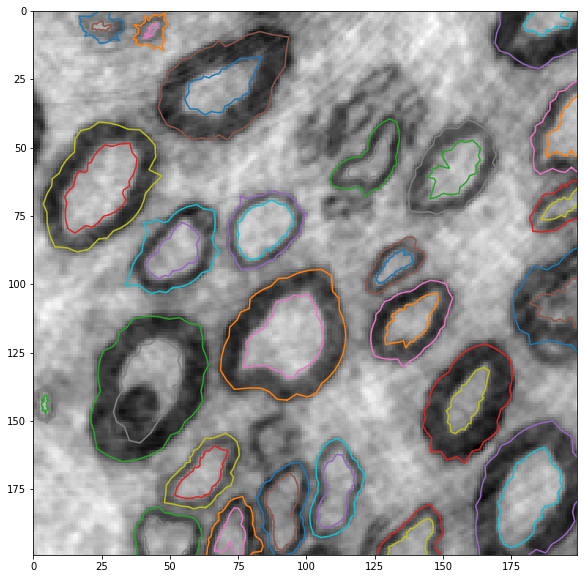

In [16]:
draw_segmentations(data, helper)

Which yields a better overall segmentation